In [10]:
import numpy as np
import cmath
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

$H_z(x,y,z) = A_{mn}cos(\frac{m\pi x}{a})cos(\frac{n\pi y}{b})e^{-j\beta z}$

In [126]:
class Modo_TEmn():
    def __init__(self, largura = 22.86, 
                 altura = 10.16, 
                 frequencia = 12*10**9, 
                 permissividade = 1, 
                 permeabilidade = 1 , 
                 plano = 'xy'):
        
        self.plano = plano
        
        self.pi = np.pi

        self.A = 1 # Amplitude
        self.frequencia = frequencia # (Hz)

        self.vacuo = False
        self.m = 1
        self.n = 0


        # Dados da página 36 da dissertação
        self.largura = largura/1000 # = a (m)
        self.altura = altura/1000 # = b (m)
        self.profundidade = 0.1 # profundidade é sempre fixa?

        self.mu = permissividade # Permissividade Relativa
        self.epsilon = permeabilidade # Permeabilidade relativa
        
        self.light_speed = 299792458 # m/s
        self.pontos_por_dimensao = 50

        self.omega = self.omega() # Frequência angular
        self.k = self.k() # Número de Onda:
        self.k_c = self.k_c() # Número de Onda de corte, que depende de corte e da geometria
        self.beta = self.beta() 

        self.escolha_plano()
        self.cos_mx = self.cosseno_x()
        self.cos_ny = self.cosseno_y()
        self.sen_mx = self.seno_x()
        self.sen_ny = self.seno_y()
        self.expz = self.exp_z()

    def criar_meshgrid_xy(self):
        x = np.linspace(0, self.largura, self.pontos_por_dimensao)
        y = np.linspace(0, self.altura, self.pontos_por_dimensao)
        X, Y = np.meshgrid(x, y, indexing='ij')
        Z = np.ones_like(X)
        return X, Y, Z

    def criar_meshgrid_xz(self):
        x = np.linspace(0, self.largura, self.pontos_por_dimensao)
        z = np.linspace(0, self.profundidade, self.pontos_por_dimensao)
        X, Z = np.meshgrid(x, z, indexing='ij')
        Y = np.ones_like(X)
        return X, Y, Z

    def criar_meshgrid_yz(self):
        y = np.linspace(0, self.altura, self.pontos_por_dimensao)
        z = np.linspace(0, self.profundidade, self.pontos_por_dimensao)
        Y, Z = np.meshgrid(y, z, indexing='ij')
        X = np.ones_like(Y)
        return X, Y, Z


    def escolha_plano(self):
        if self.plano == 'xy':
            x, y, z = self.criar_meshgrid_xy()
        elif self.plano == 'xz':
            x, y, z = self.criar_meshgrid_xz()
        elif self.plano == 'yz':
            x, y, z = self.criar_meshgrid_yz()
        
        self.x = x
        self.y = y
        self.z = z

    def omega(self):
        return self.frequencia*2*self.pi

    def k(self):
        if self.vacuo == True:
            return self.omega*np.sqrt(1/self.light_speed**2) # Mu0 * Epsilon0 = 1/c^2 No vacuo
        else:
            return self.omega*np.sqrt(self.mu*self.epsilon)


    def k_c(self):
        return (self.m*self.pi/self.largura)**2+(self.n*self.pi/self.altura)**2

    def beta(self): # Constante de fase
        return cmath.sqrt(self.k**2-self.k_c)

    def cosseno_x(self):
        return np.cos(self.m*self.pi*self.x/self.largura)
    
    def cosseno_y(self):
        return np.cos(self.n*self.pi*self.y/self.altura)

    def seno_x(self):
        return np.sin(self.m*self.pi*self.x/self.largura)

    def seno_y(self):
        return np.sin(self.n*self.pi*self.y/self.altura)

    def exp_z(self):
        return np.exp(-1j*self.beta*self.z)

    def H_z(self):
        cos_mx = self.cosseno_x()
        cos_ny = self.cosseno_y()
        expz = self.exp_z()

        return self.A*cos_mx*cos_ny*expz

    def H_x(self):
        const = 1j*self.beta*self.m*self.pi/(self.k_c**2*self.largura)
        return const*self.A*self.sen_mx*self.cos_ny*self.expz

    def H_y(self):
        const = 1j*self.beta*self.n*self.pi/(self.k_c**2*self.altura)
        return const*self.A*self.cos_mx*self.sen_ny*self.expz
    
    def E_x(self):
        const = 1j*self.omega*self.mu*self.n*self.pi/(self.k_c**2 *self.altura)
        return const*self.A*self.cos_mx*self.cos_ny*self.expz
    
    def E_y(self):
        const = -1j*self.omega*self.mu*self.m*self.pi/(self.k_c**2 *self.largura)
        return const*self.A*self.sen_mx*self.cos_ny*self.expz

    def calcula_campos(self):
        self.Hx = np.real(self.H_x())
        self.Hy = np.real(self.H_y())
        self.Hz = np.real(self.H_z())
        self.Ex = np.real(self.E_x())
        self.Ey = np.real(self.E_y())
        self.Ez = np.zeros_like(self.Ex)

        return self.Hx, self.Hy, self.Hz, self.Ex, self.Ey, self.Ez
    
    def coordenadas(self):
        return self.x, self.y, self.z
    
    def plota_campo_vetorial(self, campo = 'magnetico'):
        if self.plano == 'xy':
            abscissas = self.x
            ordenadas = self.y
            if campo == 'magnetico':
                u = self.Hx
                v = self.Hy
            elif campo == 'eletrico':
                u = self.Ex
                v = self.Ey

        elif self.plano == 'xz':
            abscissas = self.x
            ordenadas = self.z
            if campo == 'magnetico':
                u = self.Hx
                v = self.Hz
            elif campo == 'eletrico':
                u = self.Ex
                v = self.Ez

        elif self.plano == 'yz':
            abscissas = self.z
            ordenadas = self.y
            if campo == 'magnetico':
                u = self.Hz
                v = self.Hy
            elif campo == 'eletrico':
                u = self.Ez
                v = self.Ey

        plt.quiver(abscissas, ordenadas, u, v, color = 'blue')
        plt.title(f'Campo {campo} no plano {self.plano}')
        plt.grid()
        # plt.xlabel('Largura (m)')
        # plt.ylabel('Altura (m)')
        plt.show()


    def criar_plano(ax, x, y, z, cor, alpha):
        ax.plot_surface(x, y, z, color=cor, alpha=alpha, linewidth=0, antialiased=False)


    def plot3DField(self, campo = 'magnetico', componente = 'x'):
        x = self.x
        y = self.y

        if campo == 'magnetico' and componente == 'x':
            imagem = self.Hx
        elif campo == 'magnetico' and componente == 'y':
            imagem = self.Hy
        elif campo == 'magnetico' and componente == 'z':
            imagem = self.Hz
        elif campo == 'eletrico' and componente == 'x':
            imagem = self.Ex
        elif campo == 'eletrico' and componente == 'y':
            imagem = self.Ey
        elif campo == 'eletrico' and componente == 'z':
            imagem = self.Ez

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ground = min([valor for sublist in imagem for valor in sublist])
        ax.contourf(x,y,imagem, zdir='z', offset=ground, cmap='Spectral')
        ax.plot_surface(x, y, imagem, cmap='Spectral', alpha=0.7)
        
        # Adiciona rótulos e título
        ax.set_xlabel('Eixo X')
        ax.set_ylabel('Eixo Y')
        ax.set_zlabel(f'Campo {campo} na componente {componente}')
        # ax.set_title('Scatter Plot 3D com Barra de Cores')

        # Adiciona uma barra de cores
        # cbar = fig.colorbar(sc, ax=ax, label='Coordenada Z')

        # # Adiciona uma legenda (opcional)
        # ax.legend()

        # Exibição do gráfico
        plt.show()
        

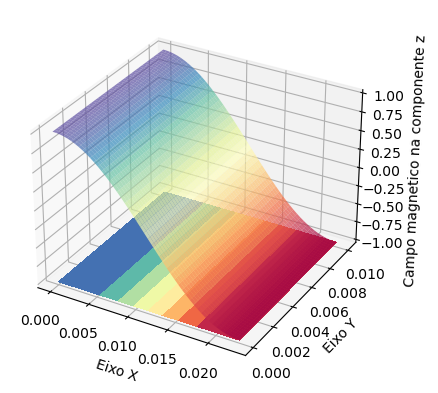

In [130]:
TEmn = Modo_TEmn(plano = 'xy') 
TEmn.calcula_campos()
# TEmn.plota_campo_vetorial('eletrico')
figura = TEmn.plot3DField(campo = 'magnetico', componente = 'z')
# figura.show()
# x, y, z = TEmn.coordenadas()

In [124]:
class Modo_TMmn():
    def __init__(self, largura = 22.86, 
                 altura = 10.16, 
                 frequencia = 12*10**9, 
                 permissividade = 1, 
                 permeabilidade = 1 , 
                 plano = 'xy'):
        
        self.plano = plano
        self.pi = np.pi
        self.B = 1
        self.frequencia = frequencia

        self.vacuo = False
        self.m = 1
        self.n = 1

        self.largura = largura/1000
        self.altura = altura/1000

        self.profundidade = 0.1 # profundidade é sempre fixa?

        self.mu = permissividade # Do ar
        self.epsilon = permeabilidade # Do ar
        
        self.light_speed = 299792458 # m/s
        self.pontos_por_dimensao = 30

        self.omega = self.omega() # Frequência angular
        self.k = self.k() # Número de Onda:
        self.k_c = self.k_c() # Número de Onda de corte, que depende de corte e da geometria
        self.beta = self.beta()

        self.escolha_plano()
        self.cos_mx = self.cosseno_x()
        self.cos_ny = self.cosseno_y()
        self.sen_mx = self.seno_x()
        self.sen_ny = self.seno_y()
        self.expz = self.exp_z()

    def criar_meshgrid_xy(self):
        x = np.linspace(0, self.largura, self.pontos_por_dimensao)
        y = np.linspace(0, self.altura, self.pontos_por_dimensao)
        X, Y = np.meshgrid(x, y, indexing='ij')
        Z = np.ones_like(X)
        return X, Y, Z

    def criar_meshgrid_xz(self):
        x = np.linspace(0, self.largura, self.pontos_por_dimensao)
        z = np.linspace(0, self.profundidade, self.pontos_por_dimensao)
        X, Z = np.meshgrid(x, z, indexing='ij')
        Y = np.ones_like(X)
        return X, Y, Z

    def criar_meshgrid_yz(self):
        y = np.linspace(0, self.altura, self.pontos_por_dimensao)
        z = np.linspace(0, self.profundidade, self.pontos_por_dimensao)
        Y, Z = np.meshgrid(y, z, indexing='ij')
        X = np.ones_like(Y)
        return X, Y, Z


    def escolha_plano(self):
        if self.plano == 'xy':
            x, y, z = self.criar_meshgrid_xy()
        elif self.plano == 'xz':
            x, y, z = self.criar_meshgrid_xz()
        elif self.plano == 'yz':
            x, y, z = self.criar_meshgrid_yz()
        
        self.x = x
        self.y = y
        self.z = z

    def omega(self):
        return self.frequencia*2*self.pi

    def k(self):
        if self.vacuo == True:
            return self.omega*np.sqrt(1/self.light_speed**2) # Mu0 * Epsilon0 = 1/c^2 No vacuo
        else:
            return self.omega*np.sqrt(self.mu*self.epsilon)

    def k_c(self):
        return (self.m*self.pi/self.largura)**2+(self.n*self.pi/self.altura)**2

    def beta(self): # Constante de fase
        return cmath.sqrt(self.k**2-self.k_c)

    def cosseno_x(self):
        return np.cos(self.m*self.pi*self.x/self.largura)

    def cosseno_y(self):
        return np.cos(self.n*self.pi*self.y/self.altura)

    def seno_x(self):
        return np.sin(self.m*self.pi*self.x/self.largura)

    def seno_y(self):
        return np.sin(self.n*self.pi*self.y/self.altura)

    def exp_z(self):
        return np.exp(-1j*self.beta*self.z)

    def E_x(self):
        const = -1j*self.omega*self.m*self.pi/(self.largura*self.k_c**2)
        return const*self.B*self.cos_mx*self.sen_ny*self.expz
    
    def E_y(self):
        const = -1j*self.omega*self.n*self.pi/(self.altura*self.k_c**2)
        return const*self.B*self.sen_mx*self.cos_ny*self.expz
    
    def E_z(self):
        return self.B*self.sen_mx*self.sen_ny*self.expz
    
    def H_x(self):
        const = 1*self.omega*self.epsilon*self.n*self.pi/(self.altura*self.k_c**2)
        return const*self.B*self.sen_mx*self.cos_ny*self.expz
    
    def H_y(self):
        const = -1*self.omega*self.epsilon*self.m*self.pi/(self.largura*self.k_c**2)
        return const*self.B*self.cos_mx*self.cos_ny*self.expz
    
    def calcula_campos(self):
        self.Ex = np.real(self.E_x())
        self.Ey = np.real(self.E_y())
        self.Ez = np.real(self.E_z())
        self.Hx = np.real(self.H_x())
        self.Hy = np.real(self.H_y())
        self.Hz = np.zeros_like(self.Hx) # Hz = 0 para todos os pontos

        return self.Hx, self.Hy, self.Hz, self.Ex, self.Ey, self.Ez

    def coordenadas(self):
        return self.x, self.y, self.z    

    def plota_campo_vetorial(self, campo = 'magnetico'):
        if self.plano == 'xy':
            abscissas = self.x
            ordenadas = self.y
            if campo == 'magnetico':
                u = self.Hx
                v = self.Hy
            elif campo == 'eletrico':
                u = self.Ex
                v = self.Ey

        elif self.plano == 'xz':
            abscissas = self.x
            ordenadas = self.z
            if campo == 'magnetico':
                u = self.Hx
                v = self.Hz
            elif campo == 'eletrico':
                u = self.Ex
                v = self.Ez

        elif self.plano == 'yz':
            abscissas = self.z
            ordenadas = self.y
            if campo == 'magnetico':
                u = self.Hz
                v = self.Hy
            elif campo == 'eletrico':
                u = self.Ez
                v = self.Ey

        plt.quiver(abscissas, ordenadas, u, v, color = 'blue')
        plt.title(f'Campo {campo} no plano {self.plano}')
        plt.grid()
        # plt.xlabel('Largura (m)')
        # plt.ylabel('Altura (m)')
        plt.show()

    def plot3DField(self, campo = 'magnetico', componente = 'x'):
        x = self.x
        y = self.y

        if campo == 'magnetico' and componente == 'x':
            imagem = self.Hx
        elif campo == 'magnetico' and componente == 'y':
            imagem = self.Hy
        elif campo == 'magnetico' and componente == 'z':
            imagem = self.Hz
        elif campo == 'eletrico' and componente == 'x':
            imagem = self.Ex
        elif campo == 'eletrico' and componente == 'y':
            imagem = self.Ey
        elif campo == 'eletrico' and componente == 'z':
            imagem = self.Ez

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ground = min([valor for sublist in imagem for valor in sublist])
        ax.contourf(x,y,imagem, zdir='z', offset=ground, cmap='Spectral')
        ax.plot_surface(x, y, imagem, cmap='Spectral', alpha=0.7)
        # Adiciona rótulos e título
        ax.set_xlabel('Eixo X')
        ax.set_ylabel('Eixo Y')
        ax.set_zlabel(f'Campo {campo} na componente {componente}')
        # ax.set_title('Scatter Plot 3D com Barra de Cores')

        # Adiciona uma barra de cores
        # cbar = fig.colorbar(sc, ax=ax, label='Coordenada Z')

        # # Adiciona uma legenda (opcional)
        # ax.legend()

        # Exibição do gráfico
        plt.show()

-790.3813268251754


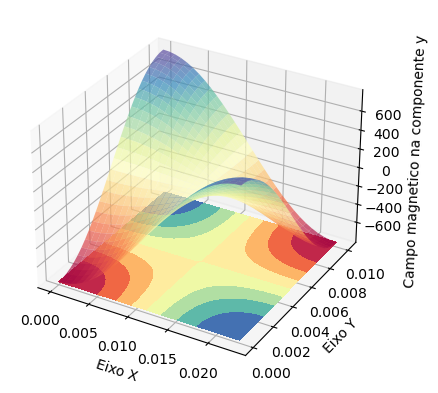

In [125]:
TEmn = Modo_TMmn(largura = 22.86, 
                 altura = 10.16, 
                 frequencia = 12*10**9, 
                 permissividade = 1, 
                 permeabilidade = 1 , 
                 plano = 'xy') 
TEmn.calcula_campos()
# TEmn.plota_campo_vetorial('eletrico')
TEmn.plot3DField(campo = 'magnetico', componente = 'y')

In [131]:
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go
from itertools import product
from matplotlib import cm
from scipy.integrate import ode as ode
from plotly.offline import init_notebook_mode